# Step 2: Model Taxonomical Order
### *Run in Google Colab Pro*

In [ ]:
# Imports & Setup:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import PIL
import PIL.Image
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

%matplotlib inline

import warnings

warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

tf.random.set_seed(42)


#Google Colab Pro Imports

#read in files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

#unpack zipped image file
import tarfile
fname = "/content/drive/MyDrive/CUB_200_2011.tgz"
fobj = tarfile.open(fname, "r")
fobj.extractall("/content")
fobj.close()

# function to load in and process images
def load_image(path):
    images = Image.open(f'/content/CUB_200_2011/images/{path}') 
    new_image=images.resize((128,128))
    color_image=new_image.convert("RGB")
    arrays1 = np.asarray(color_image)
    floaters= arrays1.astype('float32')
    floaters2=floaters/255.0
    return floaters2

#read in image directory from drive
class_map_dir= pd.read_csv('/content/drive/MyDrive/Bird-Classifications/Tables/class_map_taxonomy_directory.csv')

# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (128, 128)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#base_model.summary()

class_map_dir_train=class_map_dir.loc[class_map_dir['Is Training Image']==1]
list_of_images_train=[load_image(i) for i in class_map_dir_train['Image Name']]
array_of_img_train=np.asarray(list_of_images_train)
list_of_labels_train=class_map_dir_train['Order_Num_Seq']

class_map_dir_test=class_map_dir.loc[class_map_dir['Is Training Image']==0]
list_of_images_test=[load_image(i) for i in class_map_dir_test['Image Name']]
array_of_img_test=np.asarray(list_of_images_test)
list_of_labels_test=class_map_dir_test['Order_Num_Seq']

# sanity check length of train datasets
print(len(list_of_images_train))
print(len(list_of_labels_train))

# sanity check length of test datasets
print(len(list_of_images_test))
print(len(list_of_labels_test))

X_train_alt=array_of_img_train
y_train_alt=list_of_labels_train

X_test_alt=array_of_img_test
y_test_alt=list_of_labels_test

X_train_alt = X_train_alt.reshape(X_train_alt.shape[0], 128, 128, 3)
X_test_alt = X_test_alt.reshape(X_test_alt.shape[0], 128, 128, 3)
y_train_alt = utils.to_categorical(y_train_alt,13)
y_test_alt = utils.to_categorical(y_test_alt,13)

Mounted at /content/drive
9420800/9406464 [==============================] - 0s 0us/step
5994
5994
5794
5794


In [ ]:
model_v = Sequential([ base_model, #add in the pretrained model
  layers.RandomFlip("horizontal_and_vertical"), #implement random flip/rotation to augment the dataset. 
  layers.RandomRotation(0.15), #randomly rotate by 15 degrees
])
model_v.add(BatchNormalization())
model_v.add(Flatten(input_shape = (128, 128, 3)))
model_v.add(Dense(256, activation = 'relu'))
model_v.add(Dense(256, activation = 'relu'))
model_v.add(Dropout(0.1))
model_v.add(Dense(128, activation = 'relu', kernel_regularizer = l2(0.01)))
model_v.add(Dense(64, activation = 'relu'))
model_v.add(Dropout(0.2))
model_v.add(Dense(64, activation = 'relu', kernel_regularizer = l2(0.01)))
model_v.add(Dropout(0.2))
model_v.add(Dense(48, activation = 'relu'))

model_v.add(Dense(13, activation = 'softmax'))
# Compile model.
model_v.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model_v.trainable = True
early_stop = EarlyStopping(monitor = 'val_accuracy', min_delta=0, patience = 5, verbose = 1, mode = 'auto')
history_v  = model_v.fit(X_train_alt,
                    y_train_alt, 
                    batch_size=256,
                    validation_data=(X_test_alt, y_test_alt),
                    epochs=100,
                    verbose=1,
                    callbacks = [early_stop])

Epoch 1/100
24/24 [==============================] - 17s 260ms/step - loss: 3.3423 - accuracy: 0.6410 - val_loss: 2.6603 - val_accuracy: 0.7608
Epoch 2/100
24/24 [==============================] - 5s 195ms/step - loss: 2.2704 - accuracy: 0.7845 - val_loss: 2.0051 - val_accuracy: 0.7996
Epoch 3/100
24/24 [==============================] - 5s 196ms/step - loss: 1.6831 - accuracy: 0.8320 - val_loss: 1.5531 - val_accuracy: 0.8404
Epoch 4/100
24/24 [==============================] - 4s 161ms/step - loss: 1.2816 - accuracy: 0.8680 - val_loss: 1.2669 - val_accuracy: 0.8650
Epoch 5/100
24/24 [==============================] - 4s 161ms/step - loss: 0.9922 - accuracy: 0.9041 - val_loss: 1.1430 - val_accuracy: 0.8595
Epoch 6/100
24/24 [==============================] - 4s 160ms/step - loss: 0.7972 - accuracy: 0.9229 - val_loss: 1.0610 - val_accuracy: 0.8707
Epoch 7/100
24/24 [==============================] - 4s 160ms/step - loss: 0.6421 - accuracy: 0.9409 - val_loss: 0.9244 - val_accuracy: 0.868

In [ ]:
# summarize the model and show layers and processes
model_v.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 random_flip (RandomFlip)    (None, 4, 4, 1280)        0         
                                                                 
 random_rotation (RandomRota  (None, 4, 4, 1280)       0         
 tion)                                                           
                                                                 
 batch_normalization (BatchN  (None, 4, 4, 1280)       5120      
 ormalization)                                                   
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                        

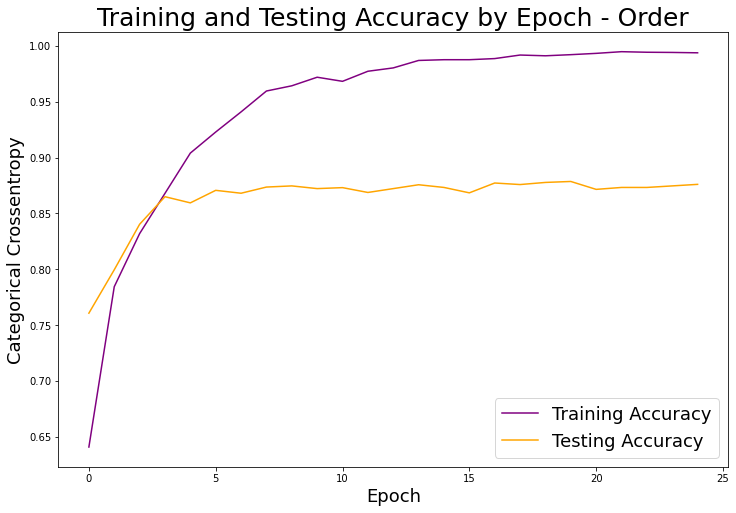

In [ ]:
# Check out our train loss and test loss over epochs.
train_loss = history_v.history['accuracy']
test_loss = history_v.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_loss, label='Training Accuracy', color='purple')
plt.plot(test_loss, label='Testing Accuracy', color='orange')

# Set title
plt.title('Training and Testing Accuracy by Epoch - Order', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)

plt.legend(fontsize = 18);

#### Model Insights:
* Once the model reached approximately 10 epochs, the testing accuracy gains decreased and it leveled off at roughly 87%. Early stopping ended the iteration at 25 epochs.
* Although I added l2 regularization and drop out layers, our model was overfit, where training accuracy was roughly 99.83%.

In [ ]:
# read in class names for order, convert to title text format
class_names=[
"ANSERIFORMES",
"CAPRIMULGIFORMES",
"CHARADRIIFORMES",
"CORACIIFORMES",
"CUCULIFORMES",
"GAVIIFORMES",
"PASSERIFORMES",
"PELECANIFORMES",
"PICIFORMES",
"PODICIPEDIFORMES",
"PROCELLARIIFORMES",
"SULIFORMES"
]

proper_class_names=[i.title() for i in class_names]

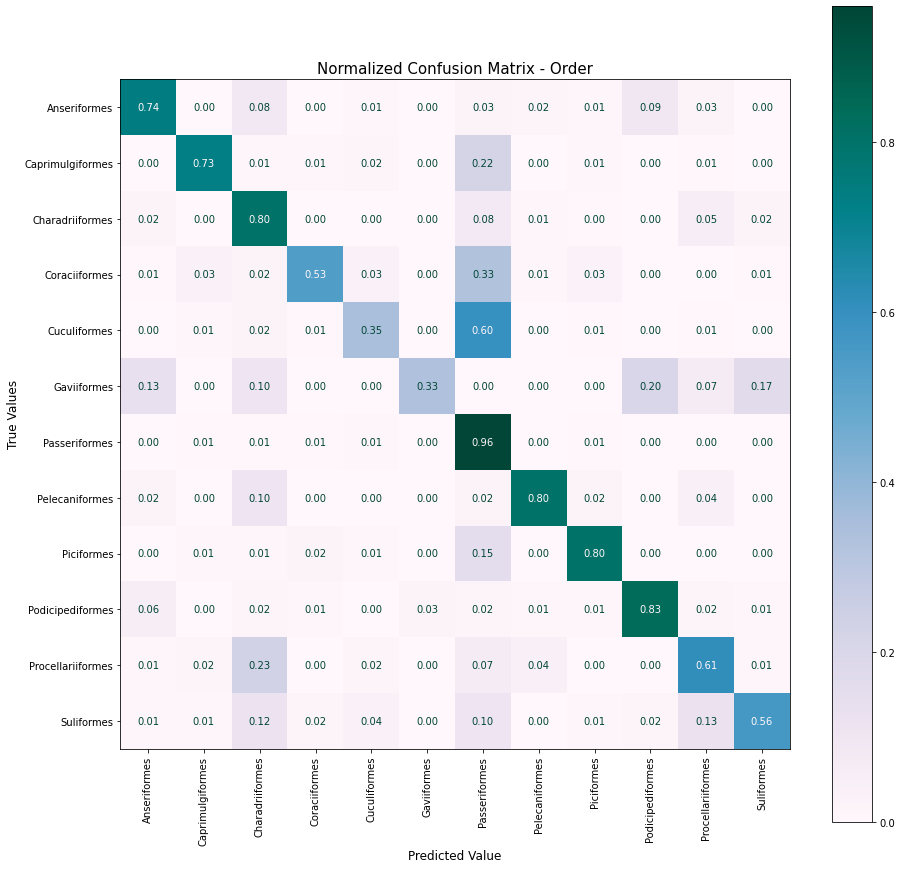

In [ ]:
# Prep data for confusion matrix
predictions=model_v.predict(X_test_alt) 
pred_f=np.argmax(predictions,axis=1)
y_test_f=np.argmax(y_test_alt,axis=1)

# build normalized confusion matrix display to understand performance by order 
cm = metrics.confusion_matrix(y_test_f, pred_f, normalize='true') #set normalize = true to see the % distribution by row 
fig, ax = plt.subplots(figsize=(15, 15))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=proper_class_names)
ax.set_title('Normalized Confusion Matrix - Order', fontsize=15)
disp.plot(ax=ax, cmap='PuBuGn',values_format='.2f')
plt.xticks(rotation=90)
plt.xlabel('Predicted Value', fontsize = 12)
plt.ylabel('True Values', fontsize = 12)
plt.savefig('Visualizations/order_confusion_matrix.png');

#### Classification Matrix Insights:
* The model did very well in accurately classifying Passeriformes, Charadriiformes, and Podicipediformes. Generally, the larger classes did better which was expected.
* The model struggled in accurately classifying Cuculiformes and Gaviiformes. These are two of the smaller classes and they seemed to struggle as a result.
* The smaller classes would benefit from more data so the predictions don't always fall to the majority class. 

In [ ]:
#save the model 
model_v.save('saved_models/order_est_v2.h5')